In [1]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from HD_BET.run import run_hd_bet
from HD_BET.utils import subdirs, subfiles
import sys
import os


In [2]:
datadir = "C:/Users/noahj/OneDrive/Documents/miaproject2/MedIA_Project2"

SKULL STRIPPING

In [14]:

input_files = []
for dir in subdirs(datadir):
    input_files.extend(subfiles(dir))
output_files = [ifile[:-7]+"_bet.nii.gz" for ifile in input_files]
run_hd_bet(input_files[0:12], output_files[0:12])

File: C:/Users/noahj/OneDrive/Documents/miaproject2/MedIA_Project2\001\ADC_deformed.nii.gz
preprocessing...
image shape after preprocessing:  (121, 145, 121)
prediction (CNN id)...
0
1
2
3
4
exporting segmentation...
File: C:/Users/noahj/OneDrive/Documents/miaproject2/MedIA_Project2\001\FA_deformed.nii.gz
preprocessing...
image shape after preprocessing:  (121, 145, 121)
prediction (CNN id)...
0
1
2
3
4
exporting segmentation...
File: C:/Users/noahj/OneDrive/Documents/miaproject2/MedIA_Project2\001\T1w_1mm.nii.gz
preprocessing...
image shape after preprocessing:  (121, 145, 121)
prediction (CNN id)...
0
1
2
3
4
exporting segmentation...
File: C:/Users/noahj/OneDrive/Documents/miaproject2/MedIA_Project2\001\T2w_1mm_noalign.nii.gz
preprocessing...
image shape after preprocessing:  (121, 145, 121)
prediction (CNN id)...
0
1
2
3
4
exporting segmentation...
File: C:/Users/noahj/OneDrive/Documents/miaproject2/MedIA_Project2\002\ADC_deformed.nii.gz
preprocessing...
image shape after preproces

RIGID REGISTRATION FUNCTION

In [7]:
def registerRigid(fixed, moving, T2, lr, printmetric=False):
    # FA AND ADC REGISTRATION
    initial_transform = sitk.CenteredTransformInitializer(fixed, 
                                                        moving, 
                                                        sitk.Euler3DTransform(),
                                                        sitk.CenteredTransformInitializerFilter.GEOMETRY)

    registration_method = sitk.ImageRegistrationMethod()
    if (T2):
        registration_method.SetMetricAsANTSNeighborhoodCorrelation(radius=2)
    else:
        registration_method.SetMetricAsJointHistogramMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01, 1)

    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsGradientDescent(learningRate=lr, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    if (printmetric):
        registration_method.AddCommand(sitk.sitkIterationEvent, lambda: print('Metric value: {0}'.format(registration_method.GetMetricValue())))
    # Run optimization
    final_transform = registration_method.Execute(fixed, moving)
    # Always check the reason optimization terminated.
    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
    return final_transform

REGISTRATION LOOP

Analyzing images for patient 002
FA: (145, 174, 145), ADC: (145, 174, 145), T2w: (182, 218, 182), T1w: (182, 218, 182)
0.91451657 0.0028335715 906.63666 1144.3209


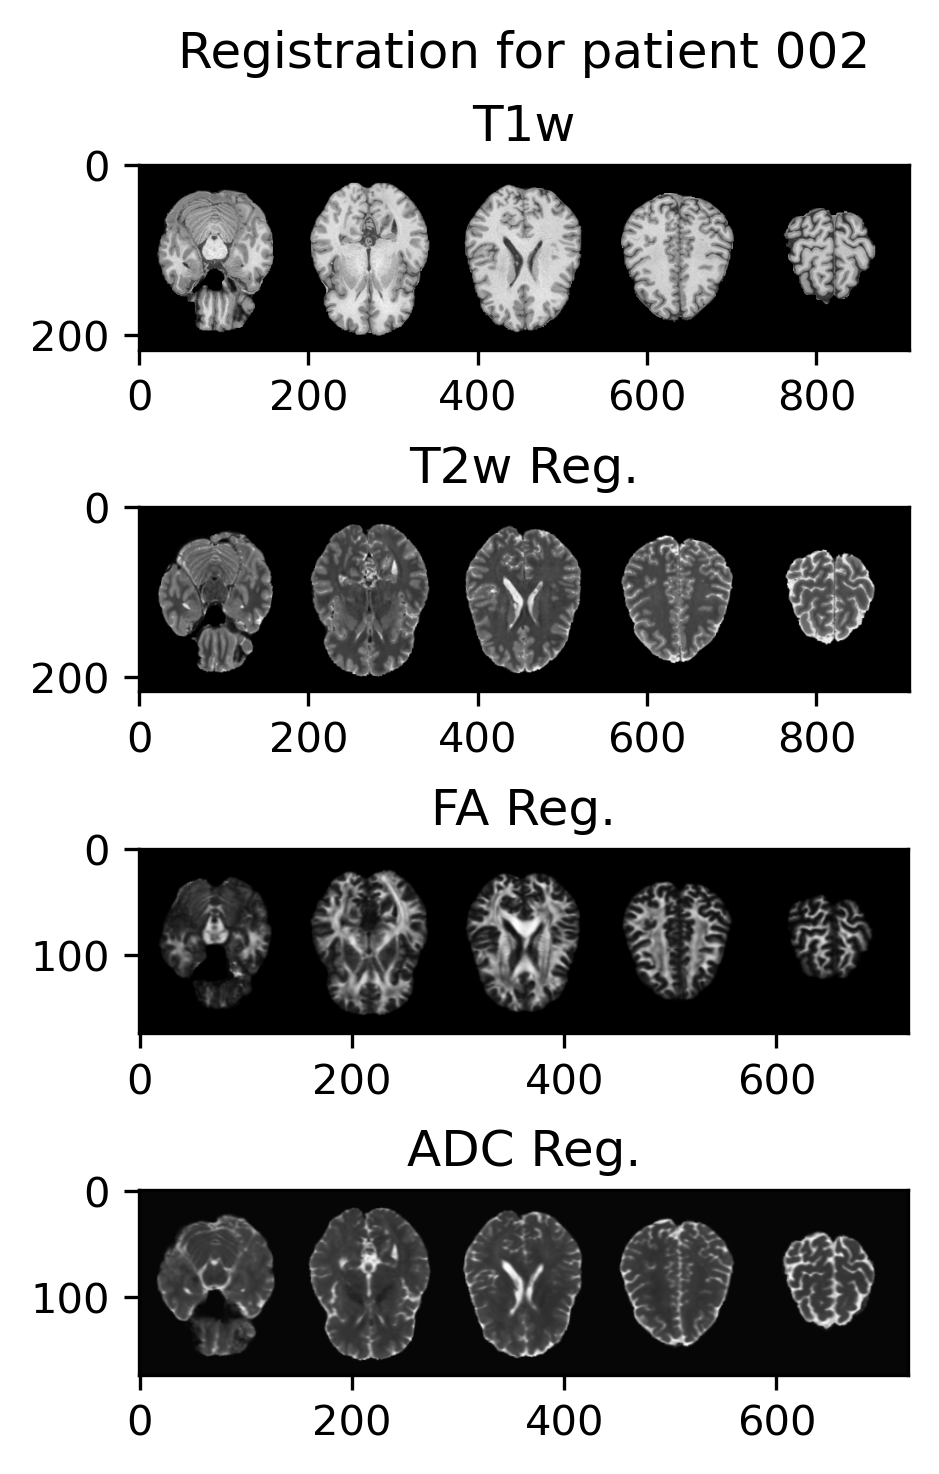

In [22]:
slices = [i/10 for i in range(3, 8)] # slices to plot for validation (given as percentage through the height)
showresults = ["001", "002", "003"] # choose the directories to plot the results for
register = False # true if we want to perform registration, otherwise we just want to plot existing registration
for dir in subdirs(datadir):
    # Run only in directories with skull-stripped images
    if dir[-3:] == "001" and os.path.exists(os.path.join(dir, "T1w_1mm_bet.nii.gz")):
        # Show current directory
        print(f"Analyzing images for patient {dir[-3:]}")

        # If we want to perform the registration
        if register:
            # Read in images
            T1w = sitk.ReadImage(os.path.join(dir, "T1w_1mm_bet.nii.gz"))
            T2w = sitk.ReadImage(os.path.join(dir, "T2w_1mm_noalign_bet.nii.gz"))
            FA = sitk.ReadImage(os.path.join(dir, "FA_deformed_bet.nii.gz"))
            ADC = sitk.ReadImage(os.path.join(dir, "ADC_deformed_bet.nii.gz"))

            # Scale FA and ADC to T1w's size
            FAscaled = sitk.Resample(FA, T1w, sitk.ScaleTransform(3, (1, 1, 1)))
            ADCscaled = sitk.Resample(ADC, T1w, sitk.ScaleTransform(3, (1, 1, 1)))

            # Run registration and obtain transformation objects
            final_transformFA = registerRigid(T1w, FAscaled, T2=False, lr=1.5)
            final_transformT2w = registerRigid(T1w, T2w, T2=True, lr=1.0, printmetric=True)

            # Apply the transformation
            ADCreg = sitk.Resample(ADCscaled, T1w, final_transformFA) # since ADC and FA have same distortion
            FAreg = sitk.Resample(FAscaled, T1w, final_transformFA)
            T2wreg = sitk.Resample(T2w, T1w, final_transformT2w)

            # Scale and save resulting registered images
            FAreg_ogsize = sitk.Resample(FAreg, FA, sitk.ScaleTransform(3, (1, 1, 1))) # scale FA back to 1.25mm res
            ADCreg_ogsize = sitk.Resample(ADCreg, ADC, sitk.ScaleTransform(3, (1, 1, 1))) # scale ADC back to 1.25mm res
            sitk.WriteImage(T2wreg, os.path.join(dir, "T2w_1mm_reg.nii.gz"))
            sitk.WriteImage(FAreg_ogsize, os.path.join(dir, "FA_reg.nii.gz"))
            sitk.WriteImage(ADCreg_ogsize, os.path.join(dir, "ADC_reg.nii.gz"))
        # If we just want to display existing registrations:
        else:
            # Ensure registered images exist, then read them in
            if not os.path.exists(os.path.join(dir, "T2w_1mm_reg.nii.gz")):
                print(f"Error: No registration found for patient {dir[-3:]}")
                break
            T1w = sitk.ReadImage(os.path.join(dir, "T1w_1mm_bet.nii.gz"))
            T2wreg = sitk.ReadImage(os.path.join(dir, "T2w_1mm_reg.nii.gz"))
            FAreg_ogsize = sitk.ReadImage(os.path.join(dir, "FA_reg.nii.gz"))
            ADCreg_ogsize = sitk.ReadImage(os.path.join(dir, "ADC_reg.nii.gz"))

        # Confirm sizes are correct
        print(f"FA: {FAreg_ogsize.GetSize()}, ADC: {ADCreg_ogsize.GetSize()}, T2w: {T2wreg.GetSize()}, T1w: {T1w.GetSize()}")

        # Plot the registration results for selected folders
        if dir[-3:] in showresults:
            # Generate tiles of multiple top-down slices to plot
            sizediff = FAreg_ogsize.GetSize()[2]
            sizeT = T1w.GetSize()[2]
            FAslices = [FAreg_ogsize[:, :, int(s*sizediff)] for s in slices]
            ADCslices = [ADCreg_ogsize[:, :, int(s*sizediff)] for s in slices]
            T2wslices = [T2wreg[:, :, int(s*sizeT)] for s in slices]
            T1wslices = [T1w[:, :, int(s*sizeT)] for s in slices]
            
            # Convert tiles to arrays for plotting
            FAarr = sitk.GetArrayFromImage(sitk.Tile(FAslices, [len(slices), 1]))
            ADCarr = sitk.GetArrayFromImage(sitk.Tile(ADCslices, [len(slices), 1]))
            T2warr = sitk.GetArrayFromImage(sitk.Tile(T2wslices, [len(slices), 1]))
            T1warr = sitk.GetArrayFromImage(sitk.Tile(T1wslices, [len(slices), 1]))
            # print(FAarr.max(), ADCarr.max(), T2warr.max(), T1warr.max())

            # Plot tiles
            fig, axs = plt.subplots(4, 1, constrained_layout=True)
            axs[0].imshow(T1warr, cmap='gray')
            axs[0].set_title("T1w")
            axs[1].imshow(T2warr, cmap='gray')
            axs[1].set_title("T2w Reg.")
            axs[2].imshow(FAarr, cmap='gray')
            axs[2].set_title("FA Reg.")
            axs[3].imshow(ADCarr, cmap='gray')
            axs[3].set_title("ADC Reg.")
            fig.suptitle(f"Registration for patient {dir[-3:]}")
            fig.set_dpi(300)

In [31]:
print(FAreg.GetSize()[0])
sitk.Show(FAreg)

182


RuntimeError: Exception thrown in SimpleITK Show: D:\a\1\sitk\Code\IO\src\sitkImageViewer.cxx:620:
sitk::ERROR: No ImageJ/Fiji application found.